Start by loading the `tidymodels` package...

In [1]:
library("tidymodels")

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6     ✔ recipes      1.1.0
✔ dials        1.3.0     ✔ rsample      1.2.1
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.5.1     ✔ tidyr        1.3.1
✔ infer        1.0.7     ✔ tune         1.2.1
✔ modeldata    1.4.0     ✔ workflows    1.1.4
✔ parsnip      1.2.1     ✔ workflowsets 1.1.0
✔ purrr        1.0.2     ✔ yardstick    1.3.1

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/



Let's work with [hotel bookings data](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md) from TidyTuesday. 

In [2]:
hotels <-
  readr::read_csv("https://tidymodels.org/start/case-study/hotels.csv", col_types = readr::cols()) |>
  mutate(across(where(is.character), as.factor)) # turns all categorical columns into factors

hotels |> head()

hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,country,market_segment,distribution_channel,⋯,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces,total_of_special_requests,arrival_date
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<date>
City_Hotel,217,1,3,2,none,BB,DEU,Offline_TA/TO,TA/TO,⋯,A,A,0,No_Deposit,0,Transient-Party,80.75,none,1,2016-09-01
City_Hotel,2,0,1,2,none,BB,PRT,Direct,Direct,⋯,D,K,0,No_Deposit,0,Transient,170.00,none,3,2017-08-25
Resort_Hotel,95,2,5,2,none,BB,GBR,Online_TA,TA/TO,⋯,A,A,2,No_Deposit,0,Transient,8.00,none,2,2016-11-19
Resort_Hotel,143,2,6,2,none,HB,ROU,Online_TA,TA/TO,⋯,A,A,0,No_Deposit,0,Transient,81.00,none,1,2016-04-26
Resort_Hotel,136,1,4,2,none,HB,PRT,Direct,Direct,⋯,F,F,0,No_Deposit,0,Transient,157.60,none,4,2016-12-28
City_Hotel,67,2,2,2,none,SC,GBR,Online_TA,TA/TO,⋯,A,A,0,No_Deposit,0,Transient,49.09,none,1,2016-03-13


Each row is a "stay" and we want to predict whether the stay included children given the other features.

We'll want to extract a bit more information from the `arrival_date` column. So, let's make a `recipe`.

In [3]:
rec = recipe(children ~ ., data = hotels) |>
    step_date(arrival_date) |>
    step_holiday(arrival_date) |>
    step_rm(arrival_date) |>
    prep()

What does this recipe do? Look at the transformed data with "juice".

In [4]:
rec |> juice() |> head()

hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,meal,country,market_segment,distribution_channel,is_repeated_guest,⋯,average_daily_rate,required_car_parking_spaces,total_of_special_requests,children,arrival_date_dow,arrival_date_month,arrival_date_year,arrival_date_LaborDay,arrival_date_NewYearsDay,arrival_date_ChristmasDay
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,⋯,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
City_Hotel,217,1,3,2,BB,DEU,Offline_TA/TO,TA/TO,0,⋯,80.75,none,1,none,Thu,Sep,2016,0,0,0
City_Hotel,2,0,1,2,BB,PRT,Direct,Direct,0,⋯,170.00,none,3,none,Fri,Aug,2017,0,0,0
Resort_Hotel,95,2,5,2,BB,GBR,Online_TA,TA/TO,0,⋯,8.00,none,2,none,Sat,Nov,2016,0,0,0
Resort_Hotel,143,2,6,2,HB,ROU,Online_TA,TA/TO,0,⋯,81.00,none,1,none,Tue,Apr,2016,0,0,0
Resort_Hotel,136,1,4,2,HB,PRT,Direct,Direct,0,⋯,157.60,none,4,none,Wed,Dec,2016,0,0,0
City_Hotel,67,2,2,2,SC,GBR,Online_TA,TA/TO,0,⋯,49.09,none,1,none,Sun,Mar,2016,0,0,0


Let's start with a decision tree. 

In [5]:
mod = decision_tree() |>
    set_engine('rpart') |>
    set_mode('classification')

In [6]:
mod_fit = mod |> fit(children ~ ., data = hotels)

In [8]:
augment(mod_fit, hotels) |> head()

.pred_class,.pred_children,.pred_none,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,⋯,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces,total_of_special_requests,arrival_date
<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,⋯,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<date>
none,0.05075292,0.9492471,City_Hotel,217,1,3,2,none,BB,⋯,A,A,0,No_Deposit,0,Transient-Party,80.75,none,1,2016-09-01
none,0.05075292,0.9492471,City_Hotel,2,0,1,2,none,BB,⋯,D,K,0,No_Deposit,0,Transient,170.00,none,3,2017-08-25
none,0.05075292,0.9492471,Resort_Hotel,95,2,5,2,none,BB,⋯,A,A,2,No_Deposit,0,Transient,8.00,none,2,2016-11-19
none,0.05075292,0.9492471,Resort_Hotel,143,2,6,2,none,HB,⋯,A,A,0,No_Deposit,0,Transient,81.00,none,1,2016-04-26
none,0.30278884,0.6972112,Resort_Hotel,136,1,4,2,none,HB,⋯,F,F,0,No_Deposit,0,Transient,157.60,none,4,2016-12-28
none,0.05075292,0.9492471,City_Hotel,67,2,2,2,none,SC,⋯,A,A,0,No_Deposit,0,Transient,49.09,none,1,2016-03-13


In [12]:
library('rpart.plot')

Warning message:
"package 'rpart.plot' was built under R version 4.4.2"
Loading required package: rpart


Attaching package: 'rpart'


The following object is masked from 'package:dials':

    prune




Use the snippet below to visualize the tree. What is the first split?

```r
rpart.plot::rpart.plot(mod_fit$fit)
```

Warning message:
"Cannot retrieve the data used to build the model (so cannot determine roundint and is.binary for the variables).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE."


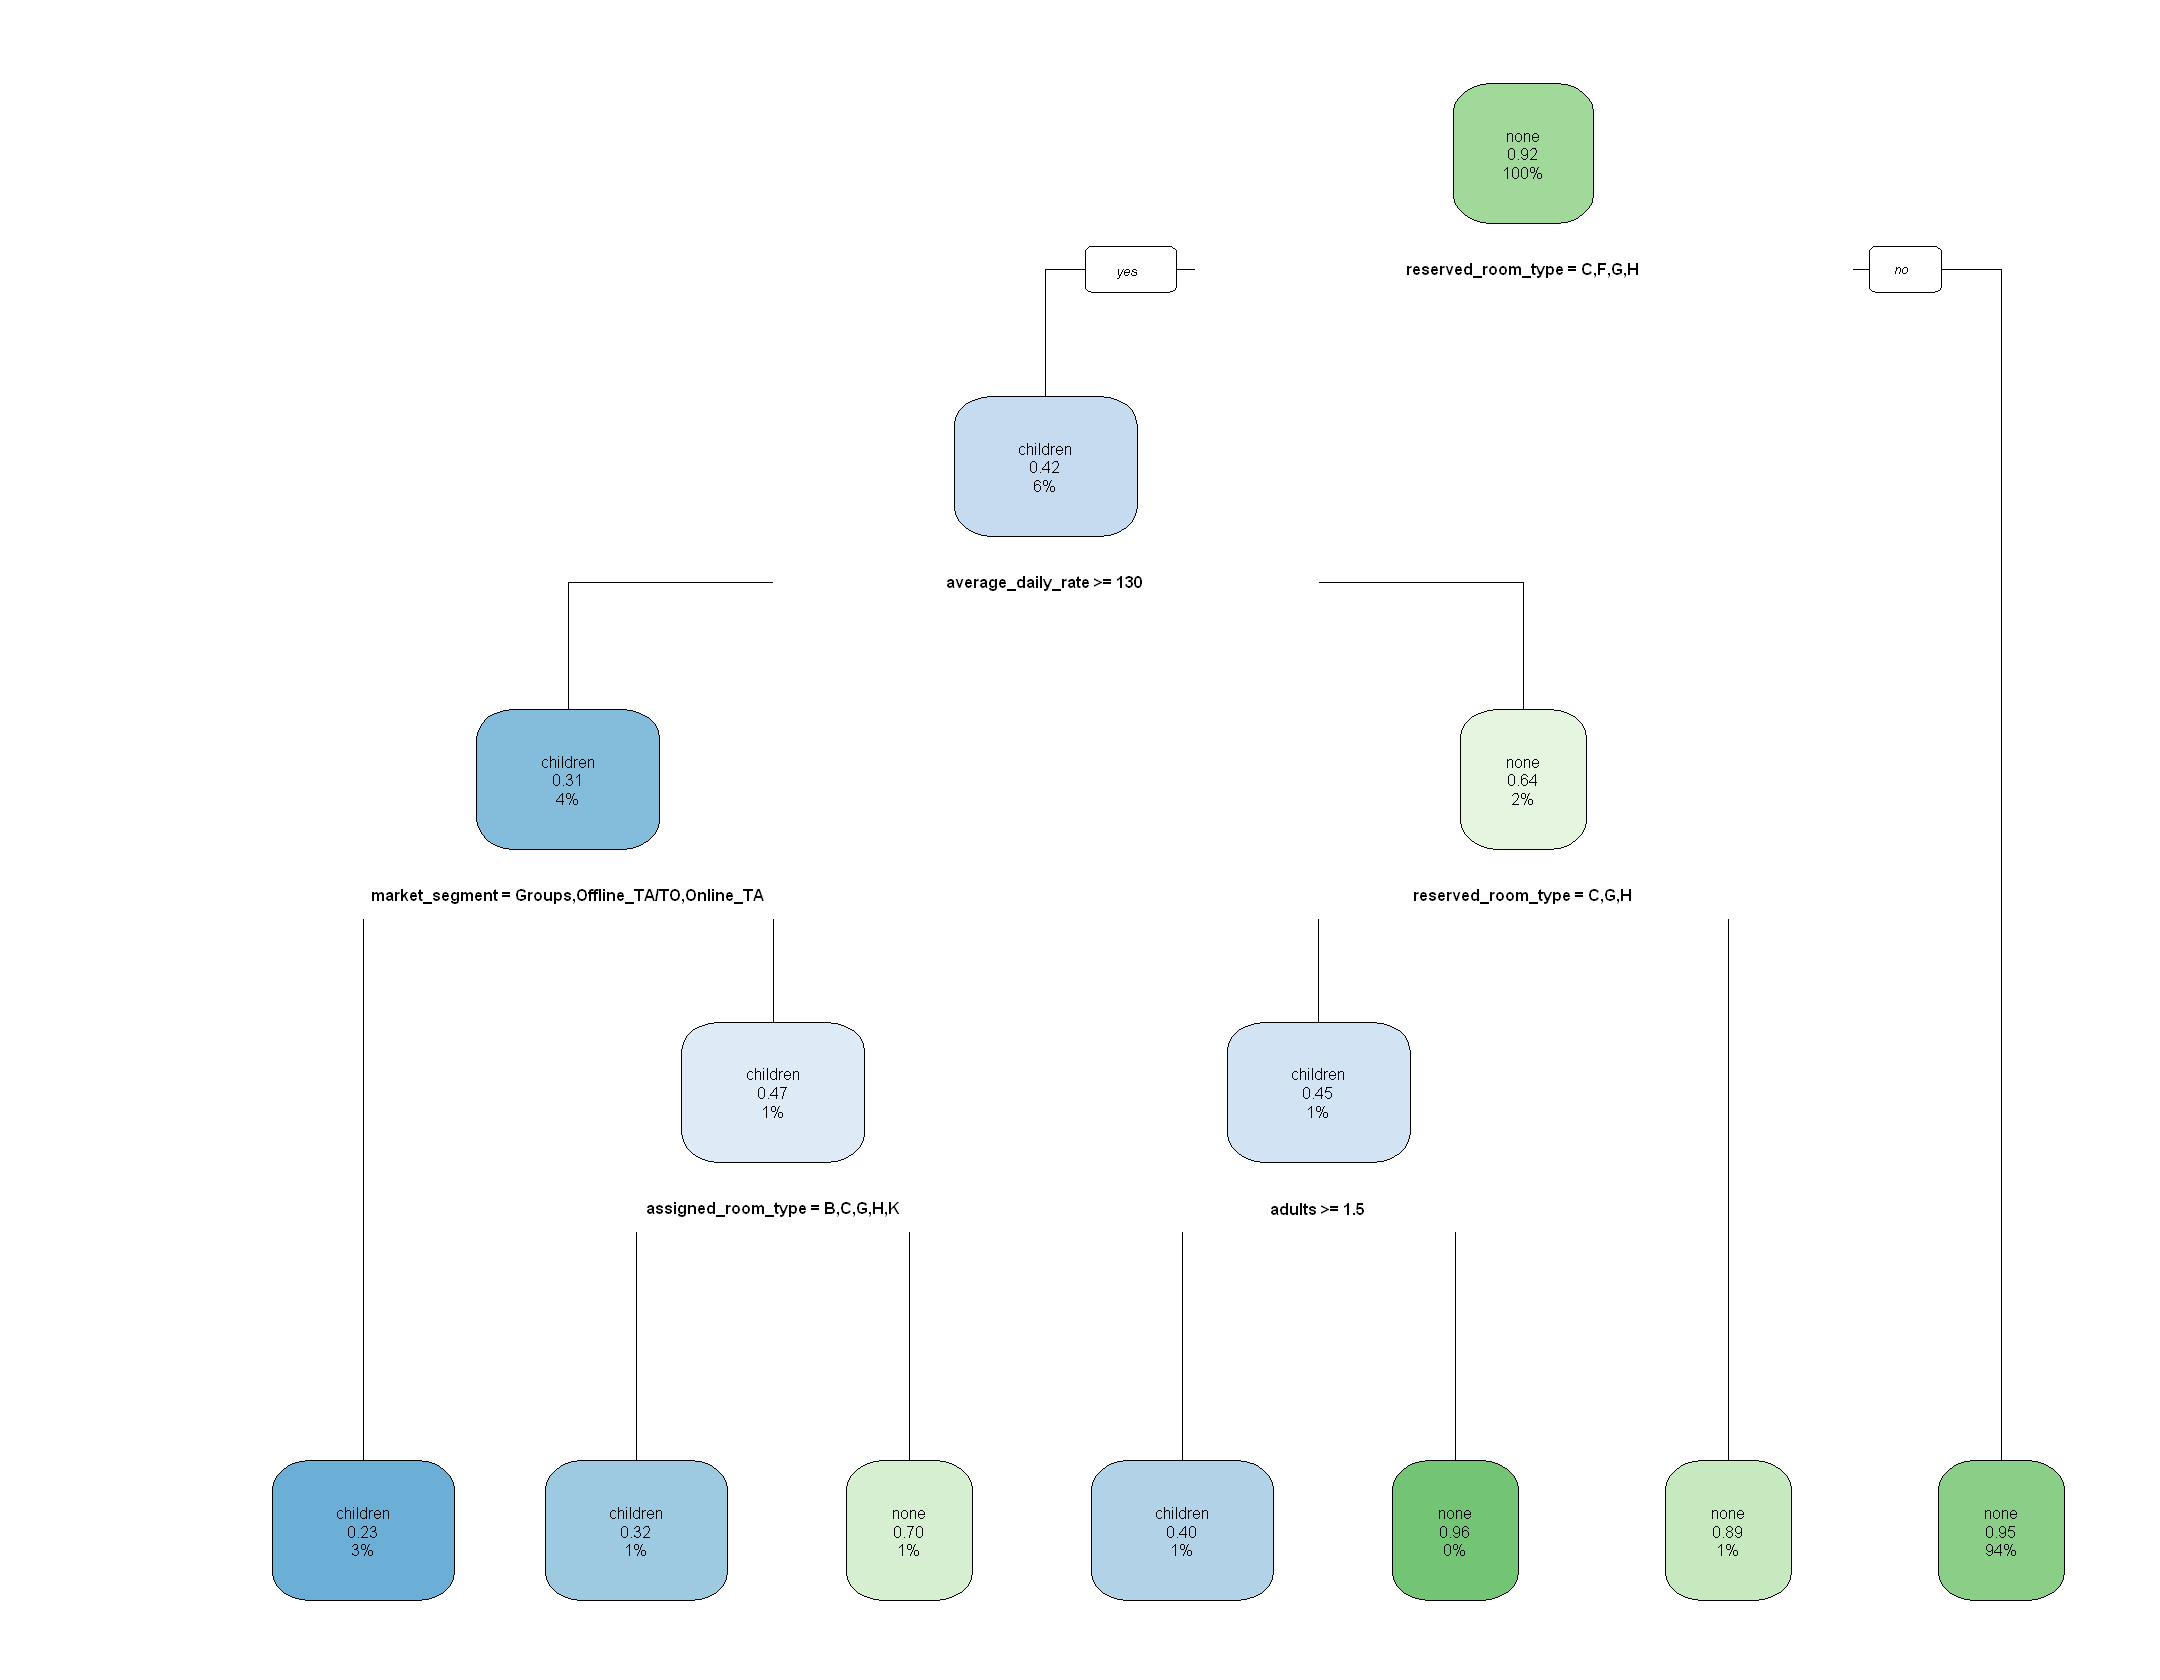

In [16]:
options(repr.plot.height = 14, repr.plot.width = 18)
theme_set(theme_gray(base_size = 16))
rpart.plot(mod_fit$fit)

Fit `mod` using the data from your prepped recipe. (Hint: remember `juice`).

In [19]:
install.packages("ranger")

Installing package into 'C:/Users/agung/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)

also installing the dependency 'RcppEigen'





  There is a binary version available but the source version is later:
       binary source needs_compilation
ranger 0.16.0 0.17.0              TRUE

  Binaries will be installed
package 'RcppEigen' successfully unpacked and MD5 sums checked
package 'ranger' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\agung\AppData\Local\Temp\RtmpCEZLjW\downloaded_packages


Now create a `random_forest` model and fit it to the transformed `hotels` data.

1. the `mode` should be "classification", and,
2. add `importance = "impurity"` to `set_engine` so we can calculate feature importances with the model.

In [20]:
mod_tree = rand_forest(trees = 1000) |>
    set_engine('ranger', importance = 'impurity',) |>
    set_mode('classification')

mod_fit_tree = mod_tree |> fit(children ~ ., data = hotels)

In [21]:
mod_fit_tree

parsnip model object

Ranger result

Call:
 ranger::ranger(x = maybe_data_frame(x), y = y, num.trees = ~1000,      importance = ~"impurity", num.threads = 1, verbose = FALSE,      seed = sample.int(10^5, 1), probability = TRUE) 

Type:                             Probability estimation 
Number of trees:                  1000 
Sample size:                      50000 
Number of independent variables:  22 
Mtry:                             4 
Target node size:                 10 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error (Brier s.):  0.04189474 

In [23]:
augment(mod_fit_tree, hotels) |> head()
augment(mod_fit_tree, hotels) |> tail()

.pred_class,.pred_children,.pred_none,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,⋯,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces,total_of_special_requests,arrival_date
<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,⋯,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<date>
none,0.002184764,0.9978152,City_Hotel,217,1,3,2,none,BB,⋯,A,A,0,No_Deposit,0,Transient-Party,80.75,none,1,2016-09-01
none,0.238853291,0.7611467,City_Hotel,2,0,1,2,none,BB,⋯,D,K,0,No_Deposit,0,Transient,170.00,none,3,2017-08-25
none,0.121510564,0.8784894,Resort_Hotel,95,2,5,2,none,BB,⋯,A,A,2,No_Deposit,0,Transient,8.00,none,2,2016-11-19
none,0.019605873,0.9803941,Resort_Hotel,143,2,6,2,none,HB,⋯,A,A,0,No_Deposit,0,Transient,81.00,none,1,2016-04-26
none,0.170343539,0.8296565,Resort_Hotel,136,1,4,2,none,HB,⋯,F,F,0,No_Deposit,0,Transient,157.60,none,4,2016-12-28
none,0.008451239,0.9915488,City_Hotel,67,2,2,2,none,SC,⋯,A,A,0,No_Deposit,0,Transient,49.09,none,1,2016-03-13


.pred_class,.pred_children,.pred_none,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,⋯,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces,total_of_special_requests,arrival_date
<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,⋯,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<date>
none,0.001786322,0.9982137,City_Hotel,73,0,2,2,none,SC,⋯,A,A,0,No_Deposit,0,Transient,79.20,none,1,2017-01-27
none,0.393470033,0.6065300,Resort_Hotel,172,0,2,2,children,BB,⋯,A,A,1,No_Deposit,0,Transient,73.39,none,1,2016-10-07
none,0.110422193,0.8895778,Resort_Hotel,48,0,4,2,none,FB,⋯,A,B,2,No_Deposit,0,Transient,158.00,none,0,2015-09-01
none,0.007673885,0.9923261,City_Hotel,155,0,4,2,none,BB,⋯,A,A,0,No_Deposit,0,Transient,82.50,none,1,2017-07-26
none,0.459660027,0.5403400,Resort_Hotel,140,2,5,2,none,HB,⋯,G,G,0,No_Deposit,0,Transient,143.00,none,0,2016-04-28
none,0.150958296,0.8490417,City_Hotel,12,2,1,2,none,BB,⋯,A,A,0,No_Deposit,0,Transient,171.33,none,1,2016-09-18


We can plot the feature importances. Pipe your fitted model into `extract_fit_parsnip()` and then into `vip(num_features = 20)`.

Warning message:
"package 'vip' was built under R version 4.4.2"

Attaching package: 'vip'


The following object is masked from 'package:utils':

    vi




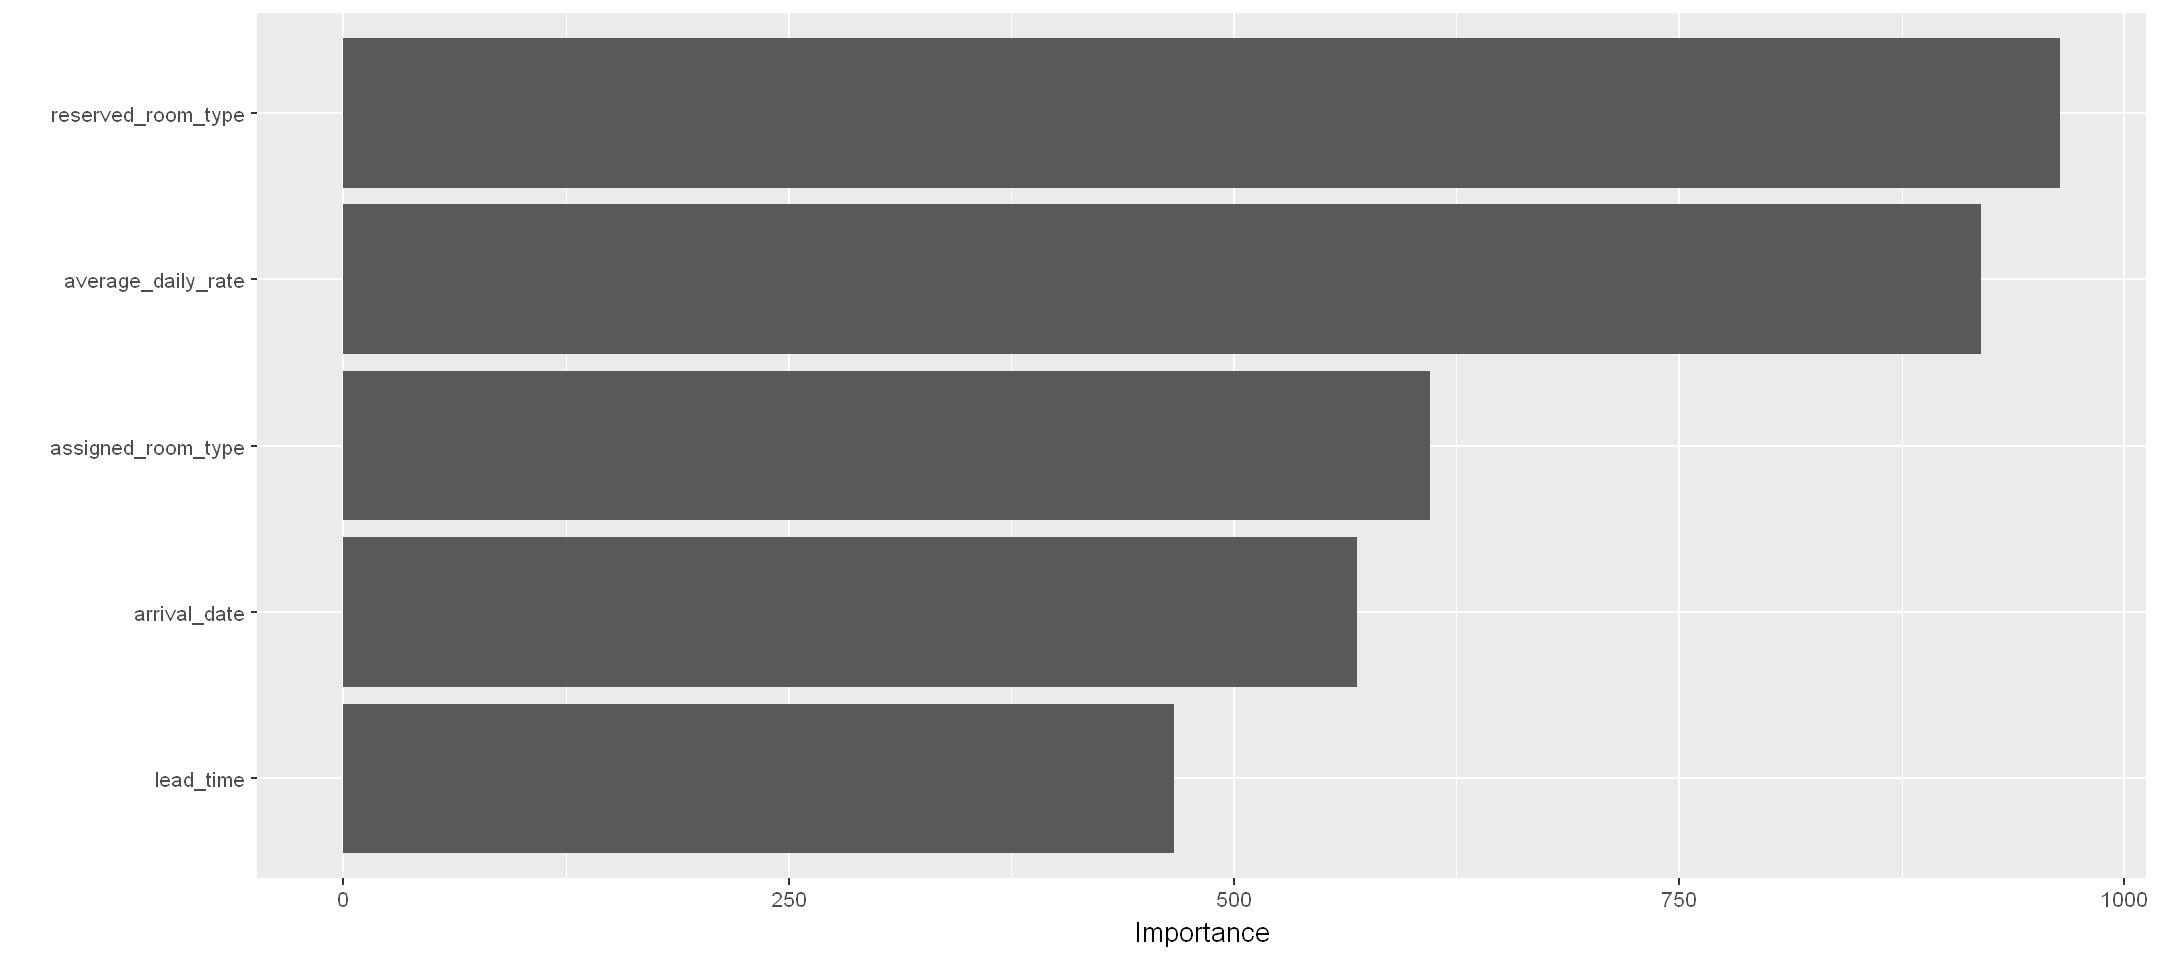

In [24]:
library('vip')
options(repr.plot.height = 8)

mod_fit_tree |> extract_fit_engine() |> vip(num_features = 5)